In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Xem ảnh

Train Images:


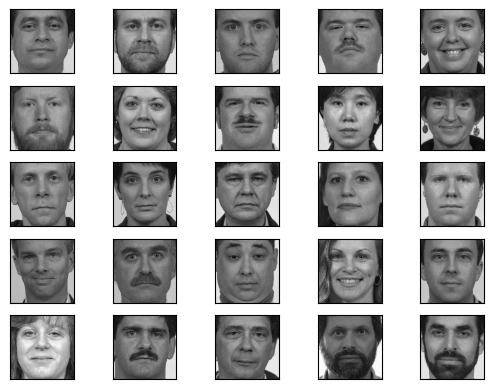

Test Images:


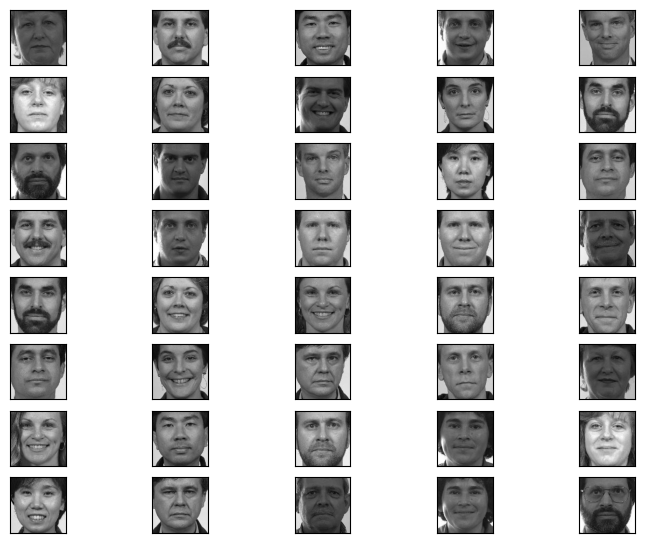

In [ ]:
import os
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np

# Đường dẫn tới thư mục chứa ảnh
TRAIN_IMG_FOLDER = '/content/drive/MyDrive/Thao/learn master 2023/đại số ma trận/đồ án cuối kỳ/images1/Training images'
TEST_IMG_FOLDER = '/content/drive/MyDrive/Thao/learn master 2023/đại số ma trận/đồ án cuối kỳ/images1/Test'

# Kích thước ảnh
width = 128
height = 128

# Đọc ảnh từ thư mục TRAIN_IMG_FOLDER
print('Train Images:')
train_image_names = os.listdir(TRAIN_IMG_FOLDER)
training_tensor = np.ndarray(shape=(len(train_image_names), height * width), dtype=np.float64)

for i in range(len(train_image_names)):
    img_path = os.path.join(TRAIN_IMG_FOLDER, train_image_names[i])  # Ghép đường dẫn an toàn
    try:
        img = imread(img_path)
        training_tensor[i, :] = np.array(img, dtype='float64').flatten()
        plt.subplot(5, 5, 1 + i)
        plt.imshow(img, cmap='gray')
        plt.tick_params(labelleft=False, labelbottom=False, bottom=False, top=False, right=False, left=False, which='both')
    except FileNotFoundError:
        print(f"File not found: {img_path}")
plt.show()

# Đọc ảnh từ thư mục TEST_IMG_FOLDER
print('Test Images:')
test_image_names = os.listdir(TEST_IMG_FOLDER)
testing_tensor = np.ndarray(shape=(len(test_image_names), height * width), dtype=np.float64)

for i in range(len(test_image_names)):
    img_path = os.path.join(TEST_IMG_FOLDER, test_image_names[i])  # Ghép đường dẫn an toàn
    try:
        img = imread(img_path)
        testing_tensor[i, :] = np.array(img, dtype='float64').flatten()
        plt.subplot(8, 5, 1 + i)
        plt.imshow(img, cmap='gray')
        plt.subplots_adjust(right=1.2, top=1.2)
        plt.tick_params(labelleft=False, labelbottom=False, bottom=False, top=False, right=False, left=False, which='both')
    except FileNotFoundError:
        print(f"File not found: {img_path}")
plt.show()


# SVD

In [ ]:
import numpy as np
from numpy.linalg import svd
import cv2
import os
import matplotlib.pyplot as plt
from typing import List, Tuple

Bước 1: Trích Xuất Đặc Trưng Từ Ảnh Huấn Luyện và Kiểm Tra

B1.1. Đọc ảnh từ thư mục và chuẩn hóa kích thước


In [ ]:
# Kích thước chuẩn cho tất cả các ảnh
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Đọc ảnh từ thư mục và chuẩn hóa kích thước
def load_images_from_folder(folder):
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img)
            labels.append(filename)
    return images, labels

B1.2. Tính SVD cho từng ảnh và tìm giá trị k tốt nhất, đồng thời tính k trung bình

In [ ]:
# Tính SVD cho từng ảnh và tìm giá trị k tốt nhất, đồng thời tính k trung bình
def calculate_best_k_for_all_images(images, explained_variance_threshold=0.99):
    best_k_values = []
    for image in images:
        # Tính SVD cho từng ảnh
        U, S, Vt = np.linalg.svd(image, full_matrices=False)

        # Tính tổng lượng thông tin được giữ lại
        total_variance = np.sum(S**2)
        explained_variance = np.cumsum(S**2) / total_variance

        # Tìm giá trị k sao cho lượng thông tin giữ lại vượt qua ngưỡng
        best_k = np.argmax(explained_variance >= explained_variance_threshold) + 1
        best_k_values.append(best_k)
    average_k = np.mean(best_k_values)
    return best_k_values, average_k

B1.3. Tính SVD cho mỗi ảnh và trích xuất đặc trưng (cho cả 2 tập ảnh)

In [ ]:
# Hàm trích xuất đặc trưng từ ảnh bằng SVD và phép dot
def extract_features(image, average_k):
    features = []

    # Tính toán SVD
    U, S, Vt = np.linalg.svd(image, full_matrices=False)

    # Đảm bảo rằng average_k là số nguyên
    average_k = int(average_k)

    # Giữ lại average_k thành phần đầu tiên của SVD để trích xuất đặc trưng
    U_reduced = U[:, :average_k]  # Giữ lại k cột đầu tiên của U
    S_reduced = np.diag(S[:average_k])  # Giữ lại k giá trị đầu tiên của S (đưa về dạng ma trận chéo)
    Vt_reduced = Vt[:average_k, :]  # Giữ lại k hàng đầu tiên của Vt

    # Tính toán giảm chiều không gian
    reduced_image = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

    # Thêm đặc trưng từ ảnh đã giảm chiều vào features (biến đổi thành vector)
    features.extend(reduced_image.flatten())

    return np.array(features)

In [ ]:
# Áp dụng hàm process_images để trích xuất đặc trưng cho tất cả ảnh
def process_images(images, average_k):
    all_features = []
    for image in images:
        features = extract_features(image, average_k)
        all_features.append(features)
    return np.array(all_features)

Bước 2: Nhận diện

2.1. Tính Khoảng Cách Euclidean và nhận diện:


In [ ]:
# Tính khoảng cách Euclidean
def euclidean_distance(X, Y):
    return np.sqrt(np.sum((X - Y) ** 2))

# Dự đoán dựa trên khoảng cách Euclidean
def predict(test_features: np.ndarray, train_features: np.ndarray, train_labels: List[str], test_labels: List[str], threshold: float = 0.01) -> Tuple[List[str], List[Tuple[str, str, float]], List[Tuple[str, str, float]]]:
    """Predict labels for test features based on training features and labels."""
    predictions, matches, recommendations = [], [], []

    for test_f, test_name in zip(test_features, test_labels):
        distances = [euclidean_distance(test_f, train_f) for train_f in train_features]
        min_index = np.argmin(distances)
        min_distance = distances[min_index]
        closest_train_name = train_labels[min_index]

        # Kiểm tra ngưỡng
        if min_distance < threshold:
            predictions.append(closest_train_name)
            matches.append((test_name, closest_train_name, min_distance))
        else:
            predictions.append("Unknown")  # Không xác định được
            recommendations.append((test_name, closest_train_name, min_distance))

    return predictions, matches, recommendations

Bước 3: Đánh Giá Kết Quả

In [ ]:
import numpy as np

def evaluate(test_labels, predictions, train_labels):
    # Số lượng dự đoán đúng - so sánh 5 ký tự đầu tiên của nhãn
    correct = np.sum([1 for i in range(len(test_labels)) if test_labels[i][:5] == predictions[i][:5]])

    # Số lượng nhận diện sai (FMR) - chỉ tính trên khuôn mặt không hợp lệ
    invalid_test_count = np.sum([1 for label in test_labels if label[:5] not in [train_label[:5] for train_label in train_labels]])
    false_matches = np.sum([1 for i in range(len(test_labels)) if test_labels[i][:5] not in [train_label[:5] for train_label in train_labels] and predictions[i] != "Unknown"])

    # Số lượng không nhận diện được (FNMR) - chỉ tính trên khuôn mặt hợp lệ
    valid_test_count = np.sum([1 for label in test_labels if label[:5] in [train_label[:5] for train_label in train_labels]])
    false_non_matches = np.sum([1 for i in range(len(test_labels)) if test_labels[i][:5] in [train_label[:5] for train_label in train_labels] and predictions[i] == "Unknown"])

    # Tính toán độ chính xác (Accuracy)
    accuracy = correct / len(test_labels)

    # Tính FMR
    if invalid_test_count > 0:
        fmr = false_matches / invalid_test_count
    else:
        fmr = 0  # Không có khuôn mặt không hợp lệ trong tập test

    # Tính FNMR
    if valid_test_count > 0:
        fnmr = false_non_matches / valid_test_count
    else:
        fnmr = 0  # Không có khuôn mặt hợp lệ trong tập test

    print(f"Độ chính xác (Accuracy): {accuracy * 100:.2f}%")
    print(f"Tỷ lệ lỗi nhận diện sai (FMR): {fmr * 100:.2f}%")
    print(f"Tỷ lệ không nhận diện được khuôn mặt đúng (FNMR): {fnmr * 100:.2f}%")

    return accuracy, fmr, fnmr


Bước 4: Hiển thị ảnh kiểm tra và ảnh khớp

In [ ]:
# Hiển thị ảnh kiểm tra và ảnh khớp
def display_matches(matches):
    for test_name, closest_train_name, min_distance in matches:
        # Tìm ảnh kiểm tra
        test_img_path = os.path.join(TEST_IMG_FOLDER, test_name)
        test_image = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)

        # Tìm ảnh huấn luyện tương ứng
        train_img_path = os.path.join(TRAIN_IMG_FOLDER, closest_train_name)
        train_image = cv2.imread(train_img_path, cv2.IMREAD_GRAYSCALE)

        # Kiểm tra xem ảnh có tồn tại hay không
        if test_image is None or train_image is None:
            print(f"Không tìm thấy ảnh: {test_img_path} hoặc {train_img_path}.")
            continue

        # Kiểm tra nếu nhãn giống nhau
        is_match = "True" if test_name[:5] == closest_train_name[:5] else "False"

        # Hiển thị ảnh
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'Test Image: {test_name}\nMatch: {is_match}')
        plt.imshow(test_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'Matched Train Image: {closest_train_name}\nDistance: {min_distance}\nMatch: {is_match}')
        plt.imshow(train_image, cmap='gray')
        plt.axis('off')

        plt.show()




In [ ]:
# Đọc ảnh từ thư mục huấn luyện
train_images, train_labels = load_images_from_folder(TRAIN_IMG_FOLDER)

# Đọc ảnh từ thư mục kiểm tra
test_images, test_labels = load_images_from_folder(TEST_IMG_FOLDER)

# Tìm k tốt nhất cho tất cả các ảnh và tính k trung bình
best_k_values, average_k = calculate_best_k_for_all_images(train_images, explained_variance_threshold=0.99)



Độ chính xác (Accuracy): 32.50%
Tỷ lệ lỗi nhận diện sai (FMR): 0.00%
Tỷ lệ không nhận diện được khuôn mặt đúng (FNMR): 50.00%


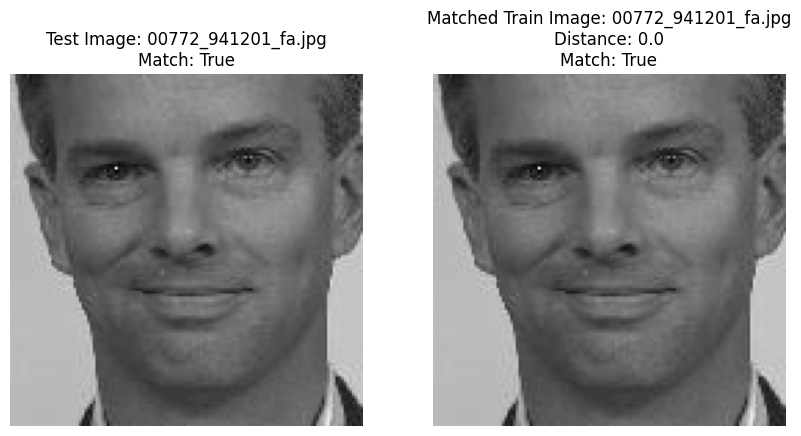

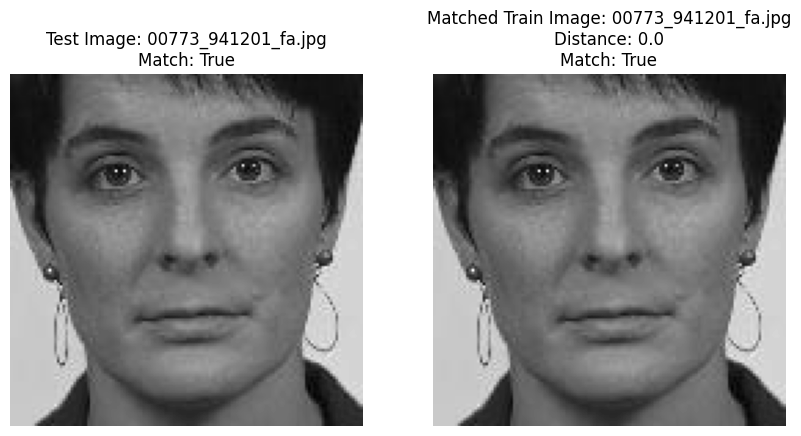

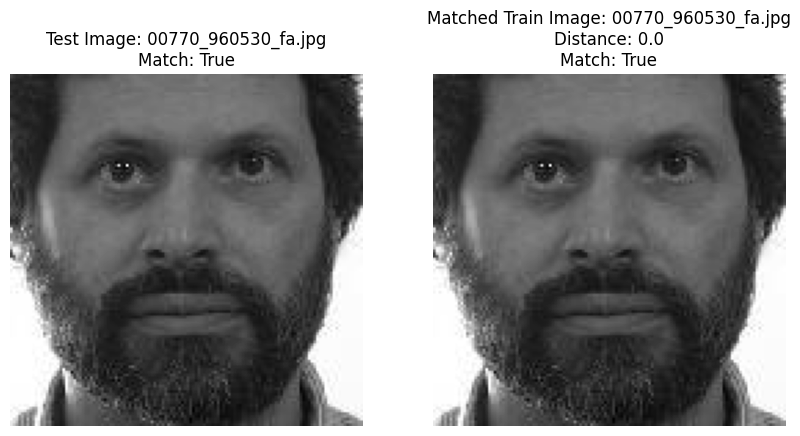

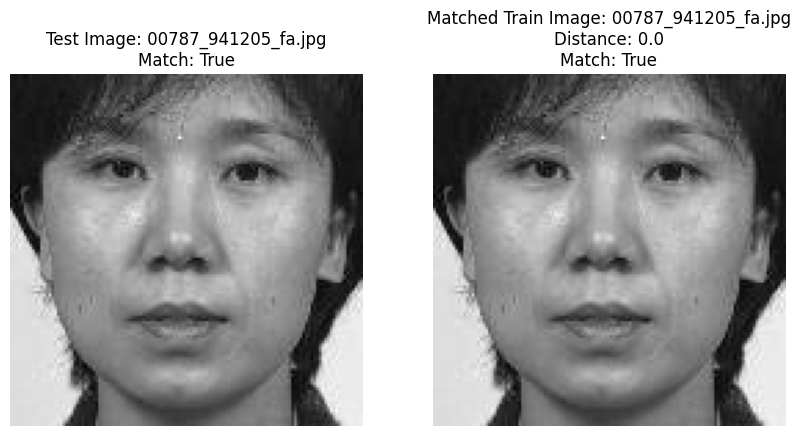

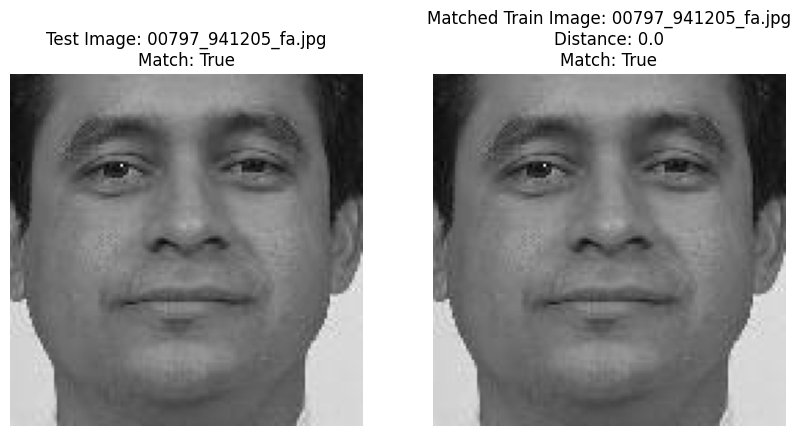

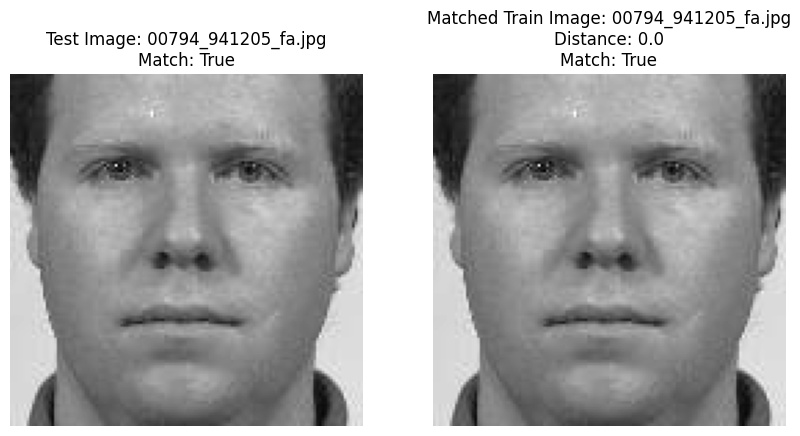

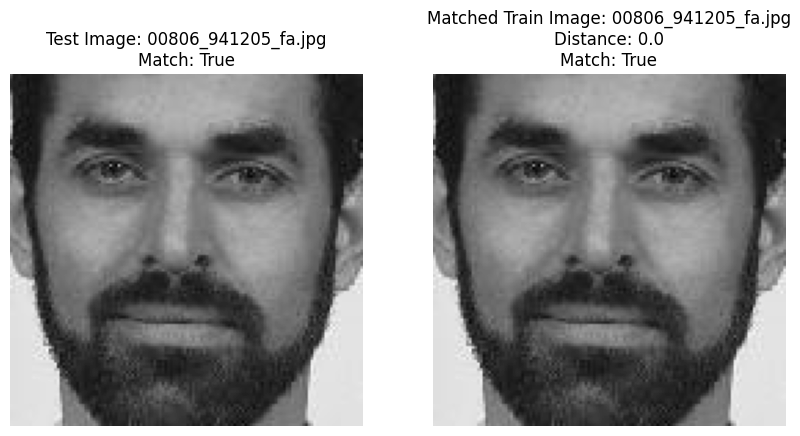

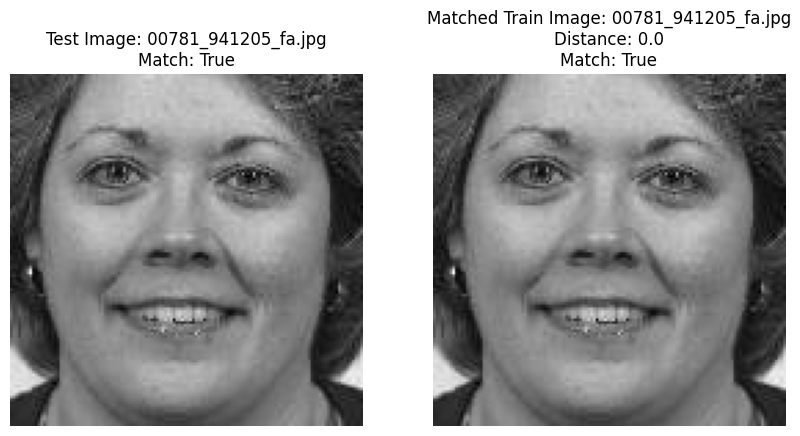

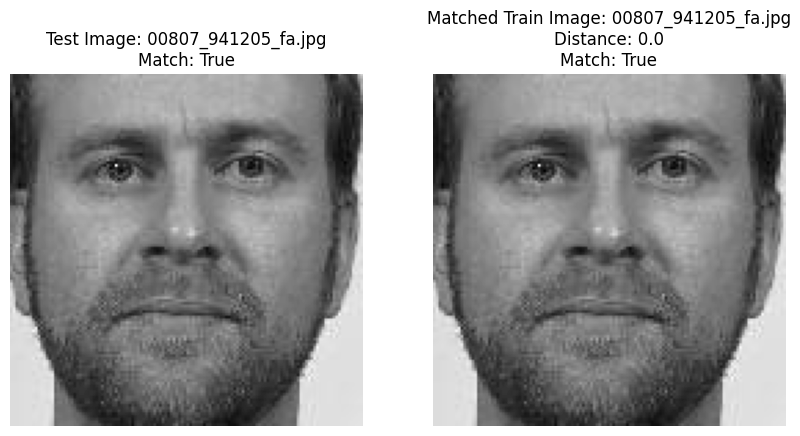

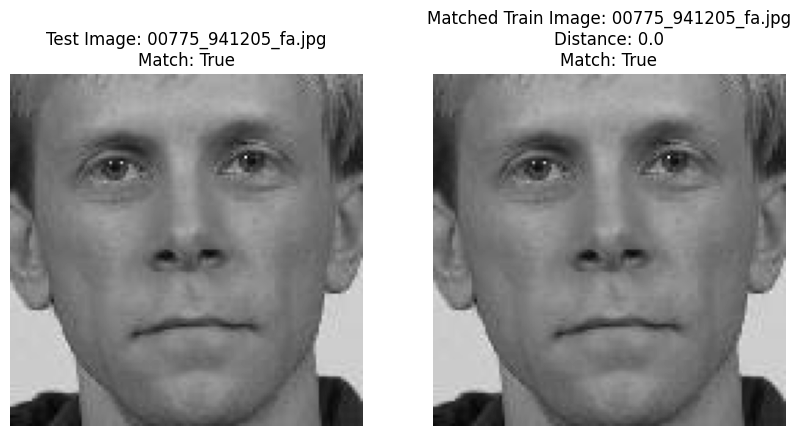

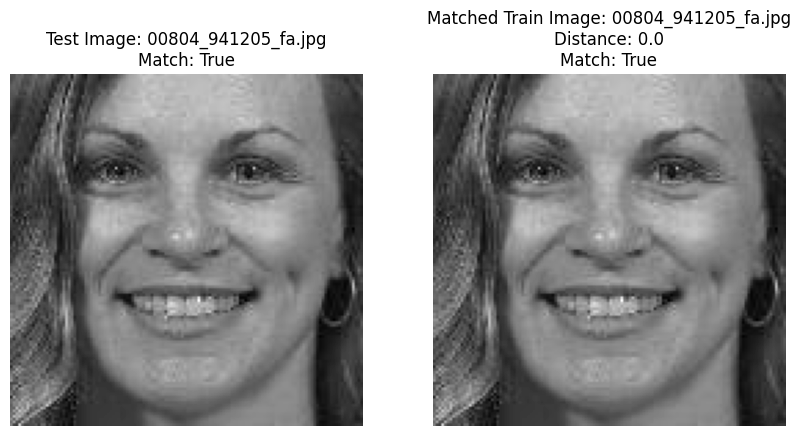

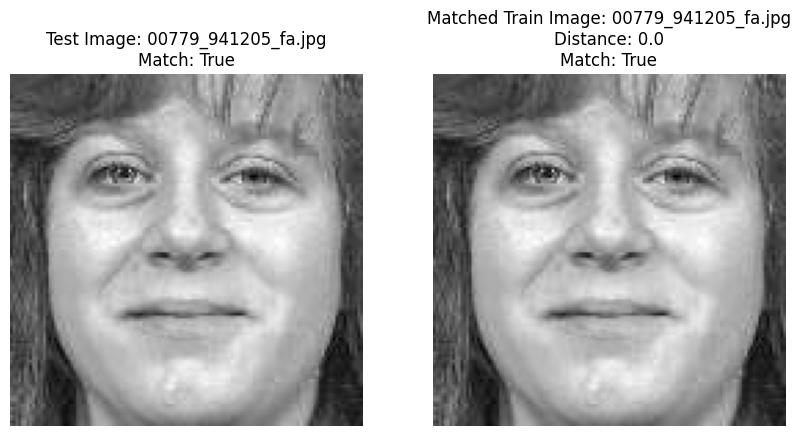

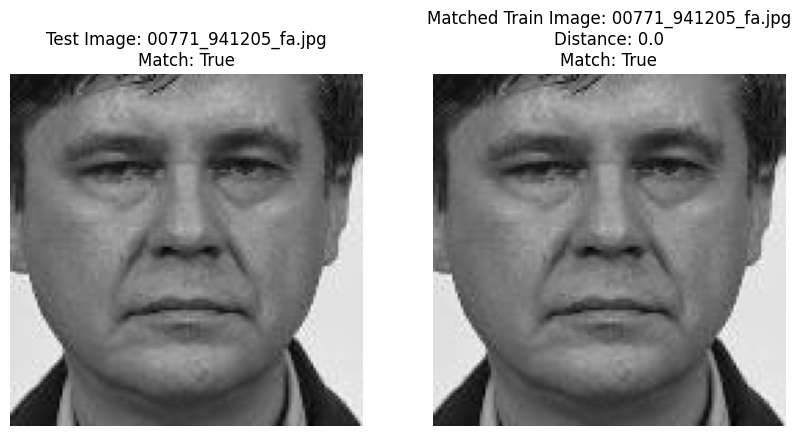


Recommendations for unknown predictions:
Test Image: 00903_960530_fa.jpg -> Closest Train Image: 00744_941201_fa.jpg with Distance: 5406.0437
Test Image: 00816_941205_fa.jpg -> Closest Train Image: 00761_941201_fa.jpg with Distance: 3362.2918
Test Image: 00809_941205_fb.jpg -> Closest Train Image: 00758_941201_fa.jpg with Distance: 4049.4599
Test Image: 00879_960530_fb.jpg -> Closest Train Image: 00772_941201_fa.jpg with Distance: 5415.3735
Test Image: 00779_941205_fb.jpg -> Closest Train Image: 00779_941205_fa.jpg with Distance: 2396.9434
Test Image: 00781_941205_fb.jpg -> Closest Train Image: 00781_941205_fa.jpg with Distance: 2373.7375
Test Image: 00876_960530_fa.jpg -> Closest Train Image: 00770_960530_fa.jpg with Distance: 4578.9321
Test Image: 00806_941205_fb.jpg -> Closest Train Image: 00806_941205_fa.jpg with Distance: 2547.0366
Test Image: 00876_960530_fb.jpg -> Closest Train Image: 00772_941201_fa.jpg with Distance: 6072.8936
Test Image: 00772_941201_fb.jpg -> Closest Train 

In [ ]:
# Trích xuất đặc trưng từ ảnh huấn luyện
train_features = process_images(train_images, average_k)

# Trích xuất đặc trưng từ ảnh kiểm tra
test_features = process_images(test_images, average_k)

# Dự đoán nhãn cho ảnh kiểm tra
predictions, matches, recommendations = predict(test_features, train_features, train_labels, test_labels)

# Đánh giá kết quả dự đoán
accuracy, fmr, fnmr = evaluate(test_labels, predictions, train_labels)

# Hiển thị ảnh khớp
display_matches(matches)

# Hiển thị các đề xuất cho các ảnh không nhận diện được
print("\nRecommendations for unknown predictions:")
for test_name, closest_train_name, min_distance in recommendations:
    print(f"Test Image: {test_name} -> Closest Train Image: {closest_train_name} with Distance: {min_distance:.4f}")

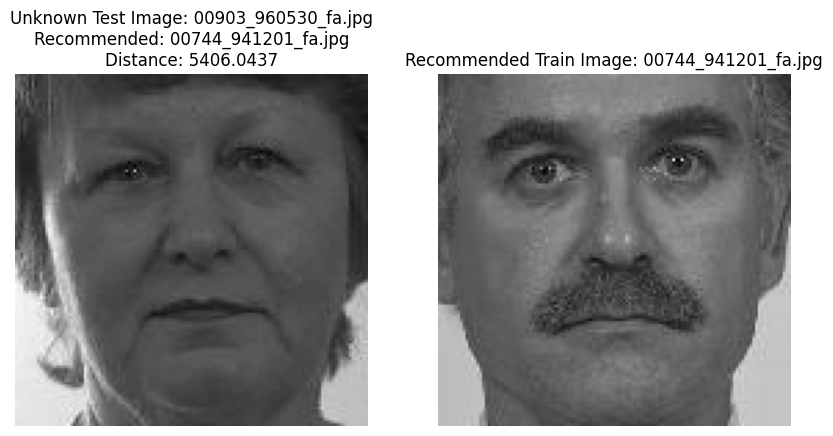

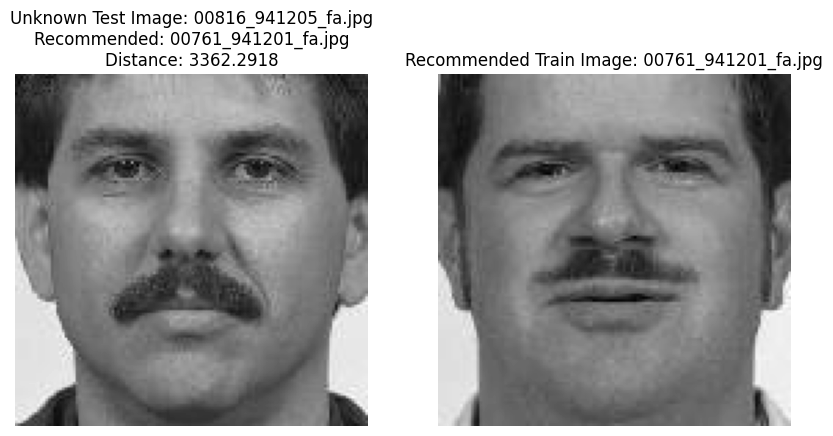

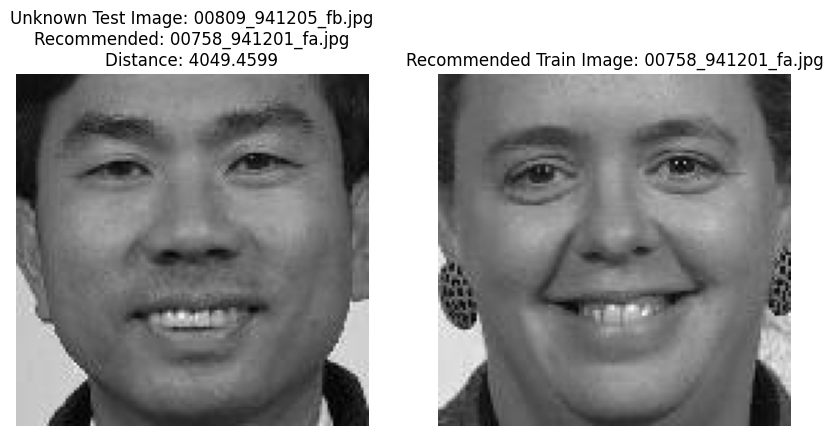

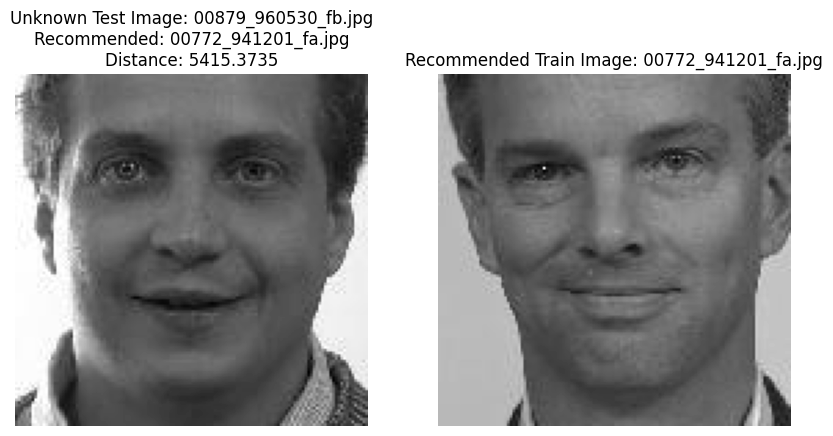

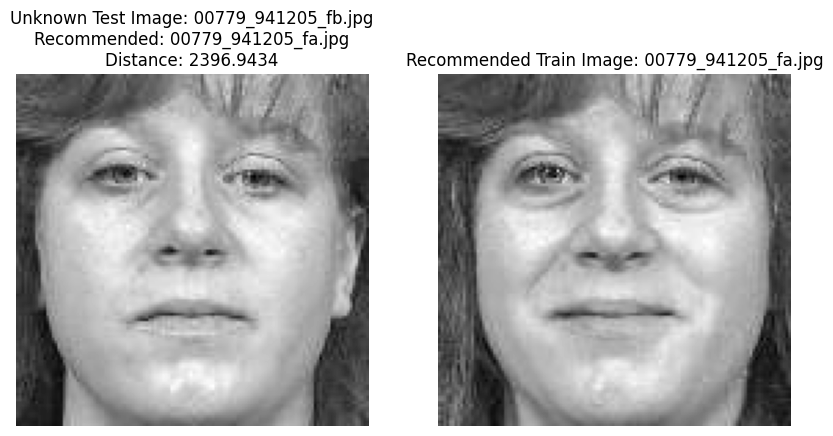

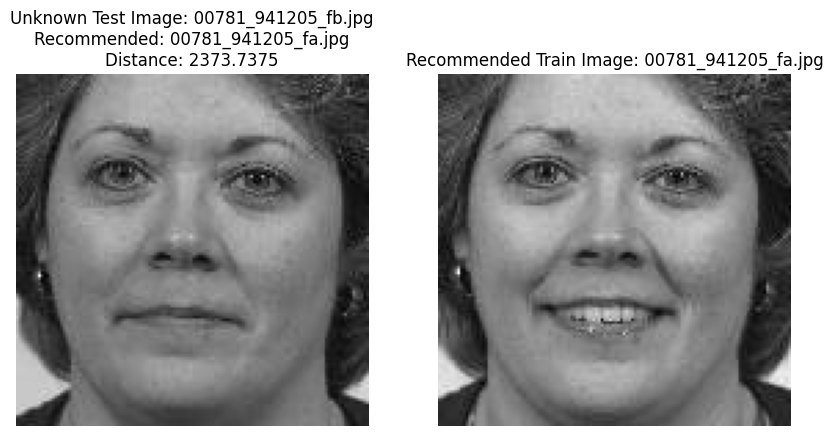

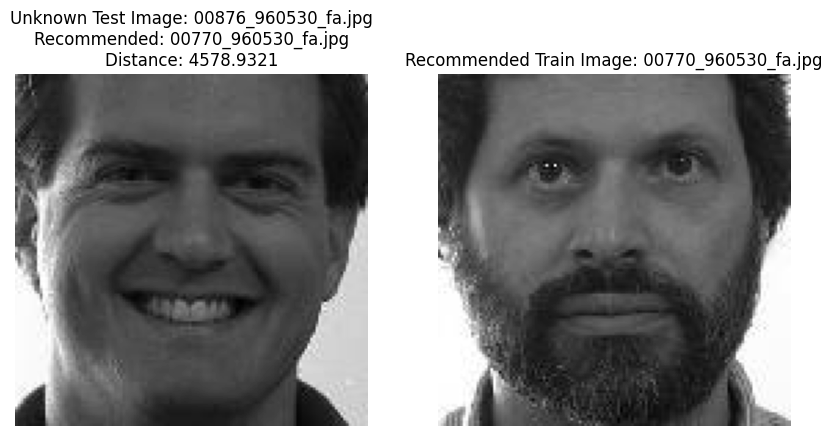

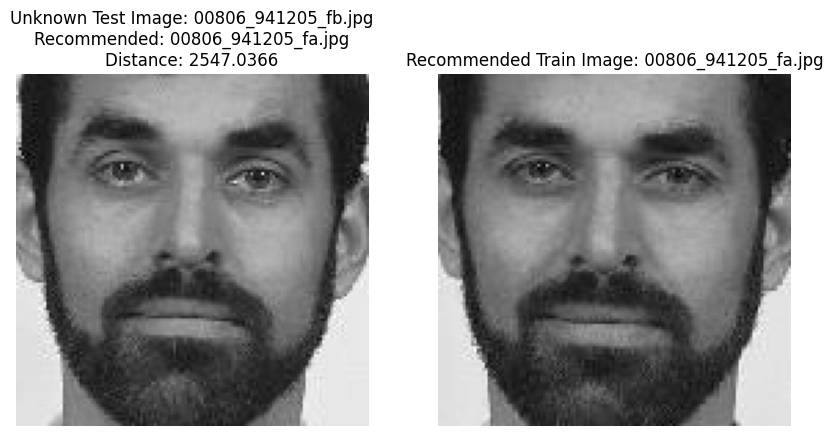

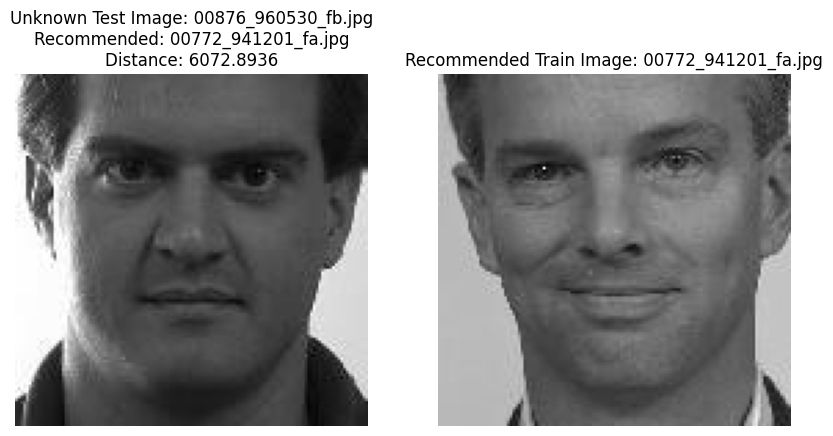

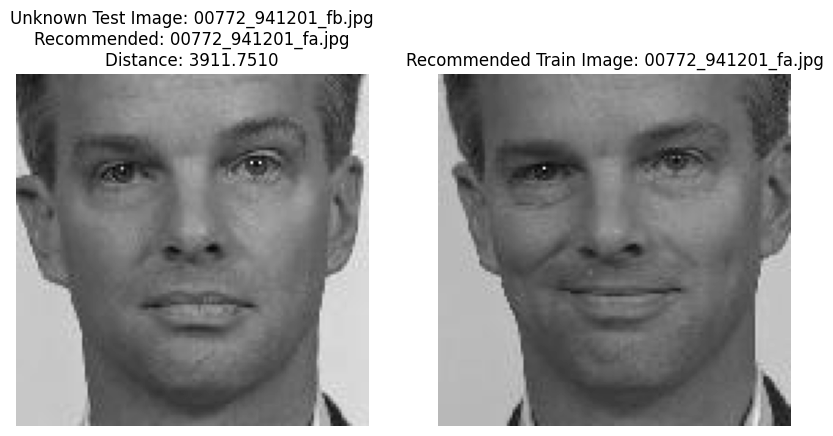

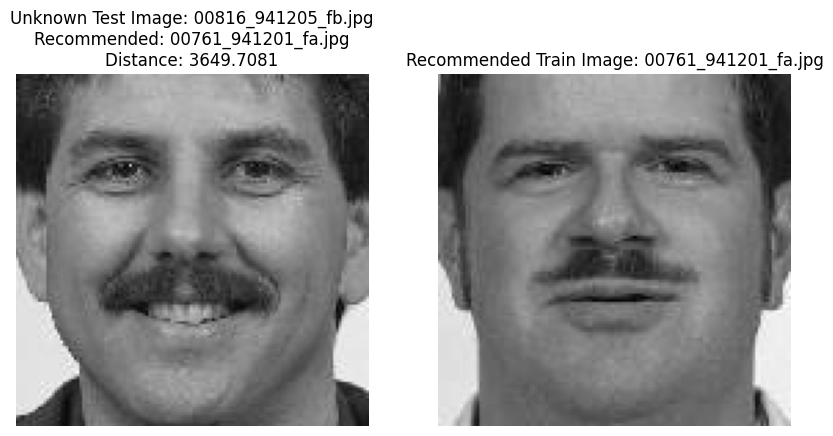

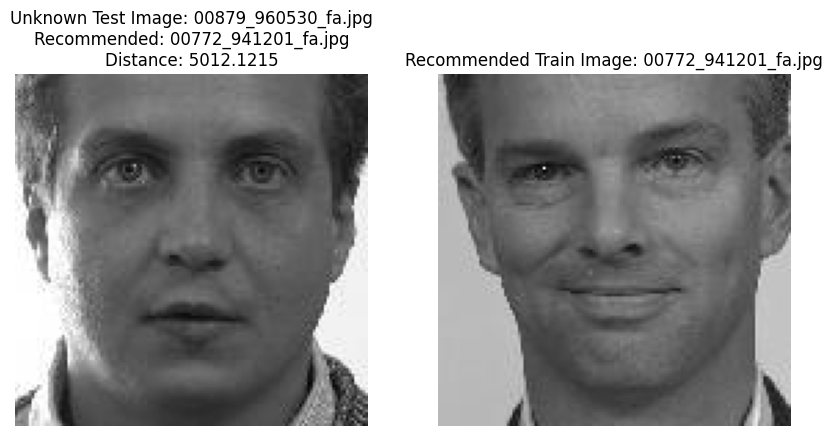

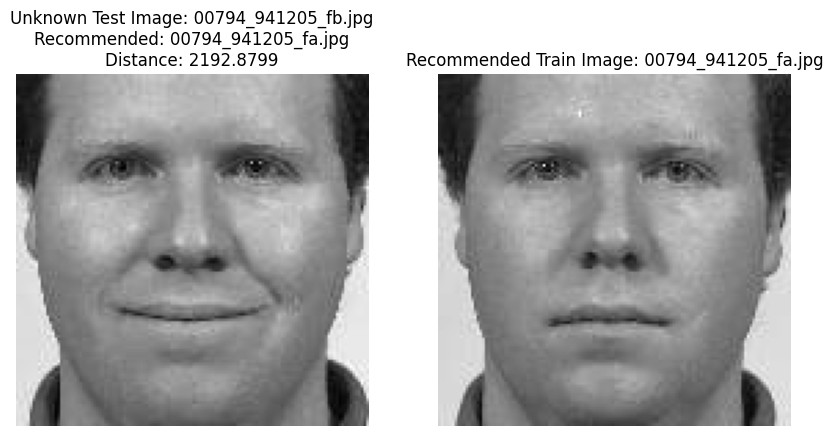

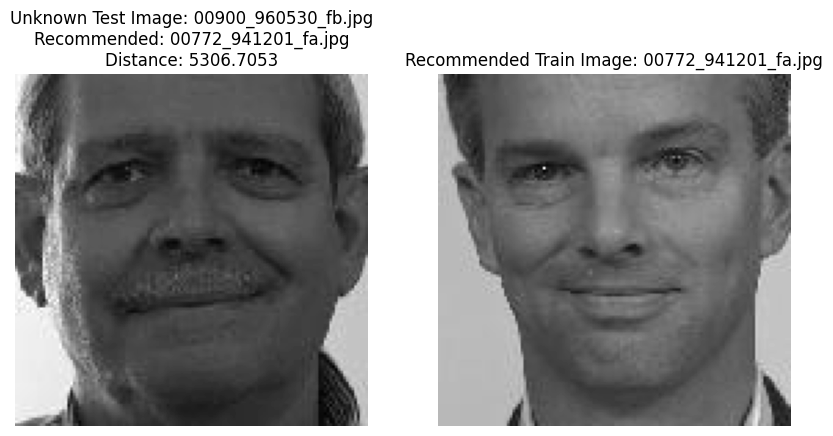

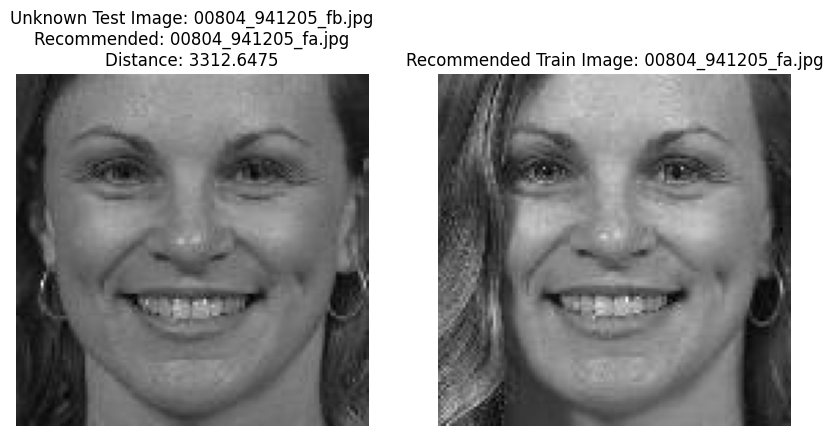

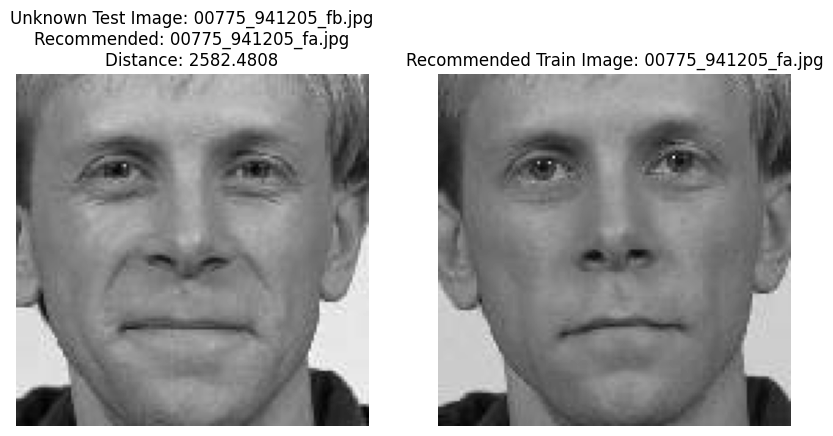

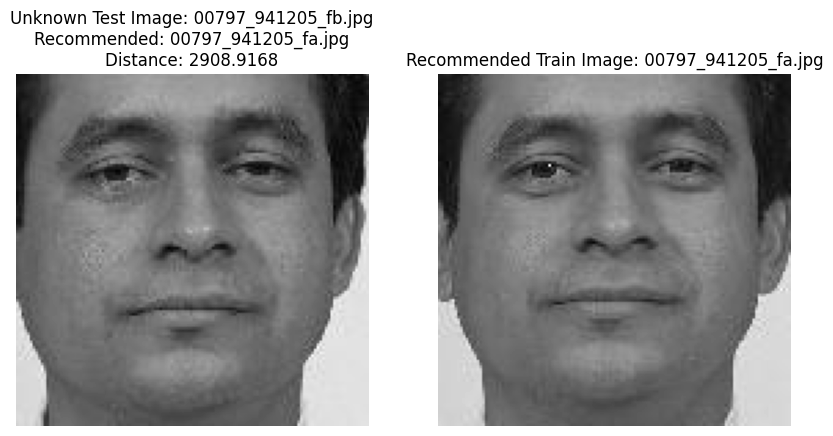

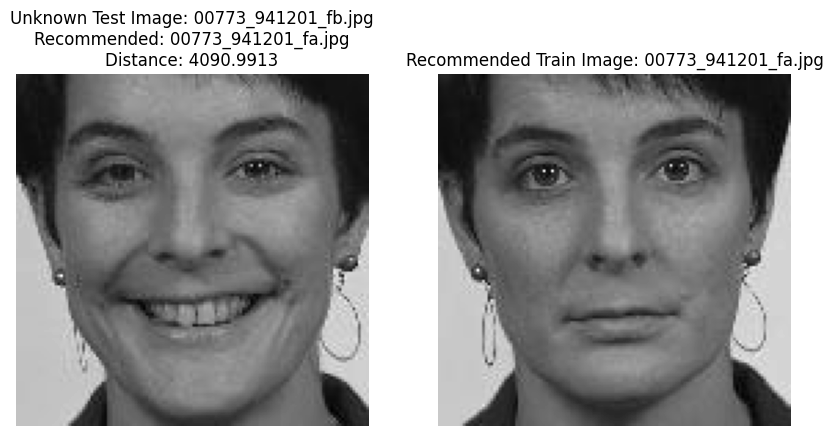

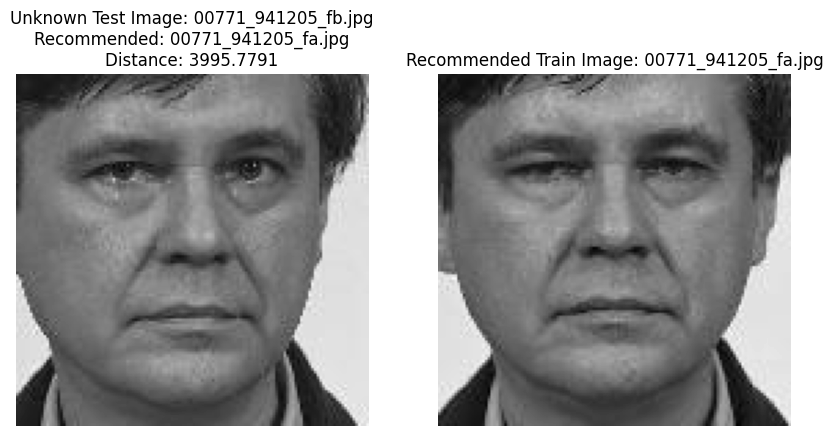

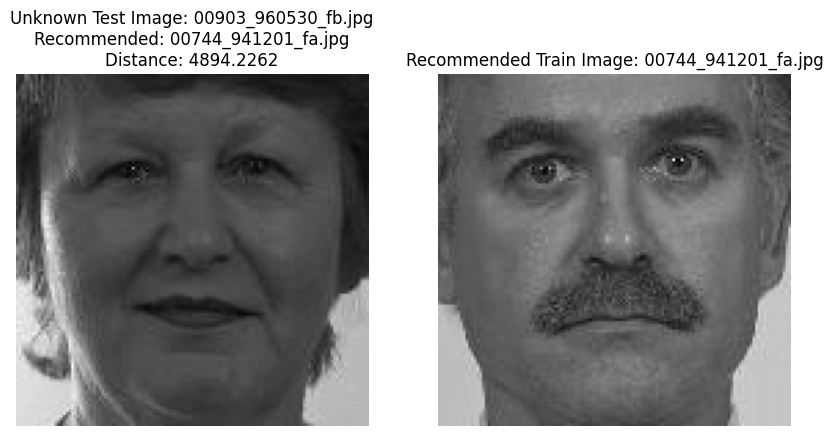

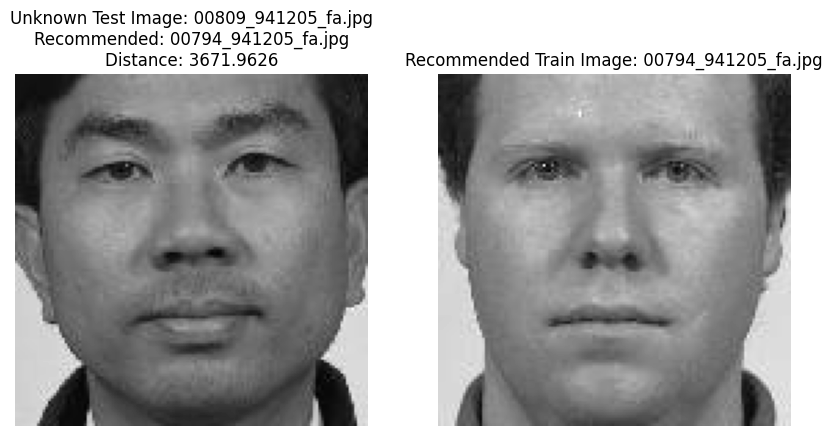

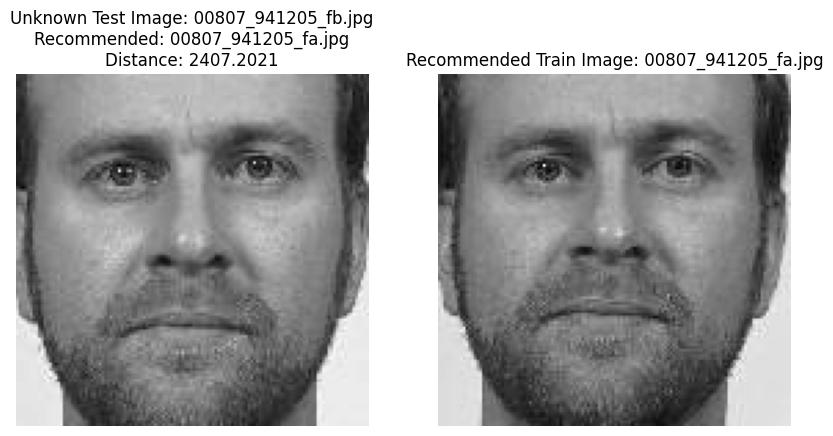

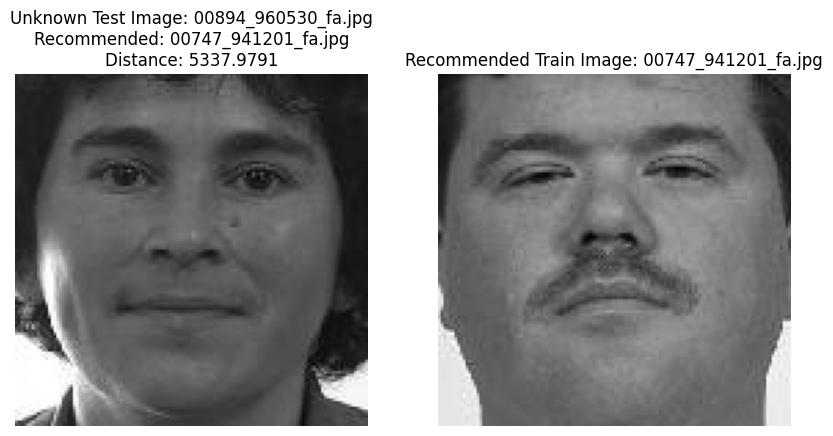

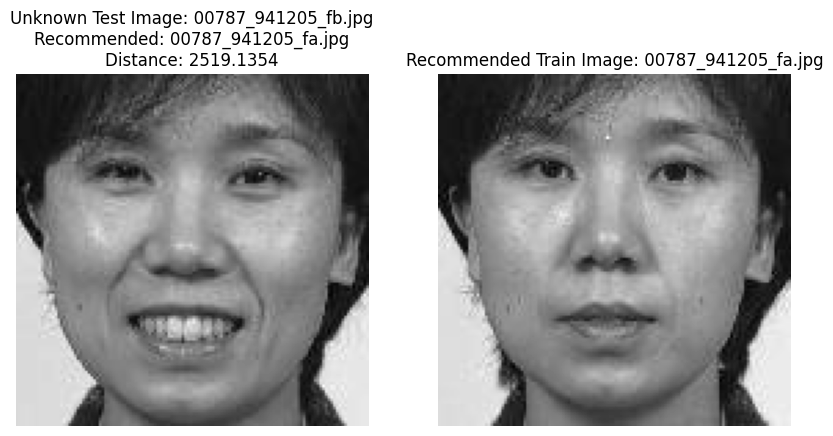

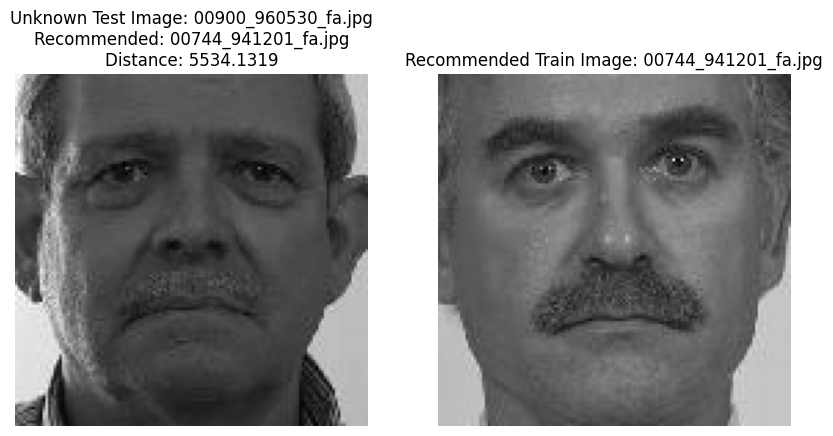

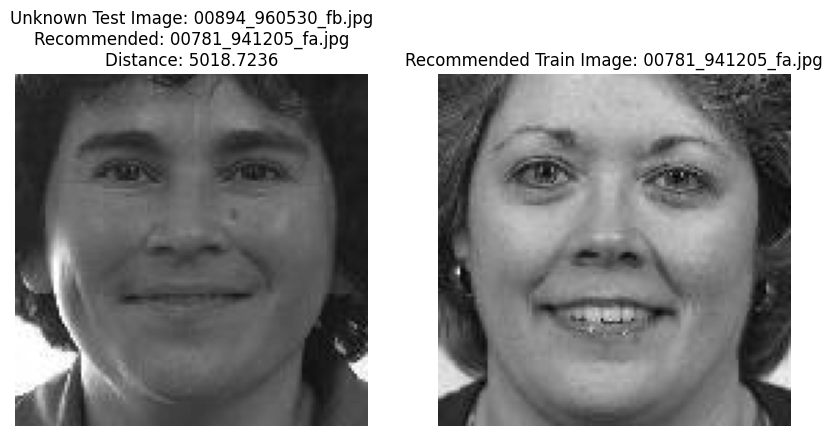

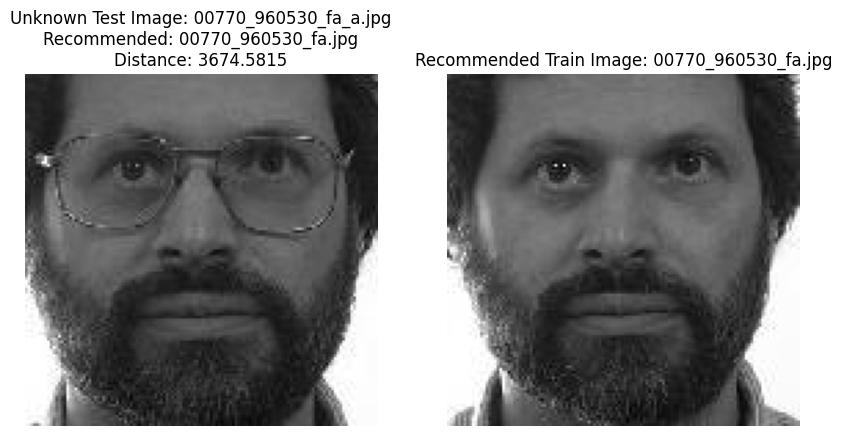

In [ ]:
# Hiển thị ảnh không nhận diện được và ảnh đề xuất
def display_unknowns(recommendations):
    for test_name, closest_train_name, min_distance in recommendations:
        # Tìm ảnh kiểm tra
        test_img_path = os.path.join(TEST_IMG_FOLDER, test_name)
        test_image = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)

        # Tìm ảnh huấn luyện tương ứng
        train_img_path = os.path.join(TRAIN_IMG_FOLDER, closest_train_name)
        train_image = cv2.imread(train_img_path, cv2.IMREAD_GRAYSCALE)

        # Kiểm tra xem ảnh có tồn tại hay không
        if test_image is None or train_image is None:
            print(f"Không tìm thấy ảnh: {test_img_path} hoặc {train_img_path}.")
            continue

        # Hiển thị ảnh không nhận diện được
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'Unknown Test Image: {test_name}\nRecommended: {closest_train_name}\nDistance: {min_distance:.4f}')
        plt.imshow(test_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'Recommended Train Image: {closest_train_name}')
        plt.imshow(train_image, cmap='gray')
        plt.axis('off')

        plt.show()

# Hiển thị ảnh không nhận diện được và ảnh đề xuất
display_unknowns(recommendations)
